# ARIMA MODELING ON APPLE DATA 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm

Getting the data

In [3]:
train_apple = pd.read_csv("train_apple.csv")
test_apple = pd.read_csv("test_apple.csv")

Merging the data as we just need the closing price for ARIMA prediction

In [4]:
apple = [train_apple , test_apple]

for df in apple:
    df.columns = ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']

apple_data = pd.concat(apple).reset_index(drop=True)


Data manipulation

In [5]:
apple_data = apple_data.sort_values("date").set_index("date")  #Sorting the dataset as per the date and setting date as the index

In [6]:
apple_data.index =  pd.to_datetime(apple_data.index)

In [7]:
apple_data.head() #Overview

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0
2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0
2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0
2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0


In [8]:
#Resampling it monthwise indicating the starting date. mean() is used to get the mean closing price value accross the time period
Y_apple = apple_data["close"].resample('MS').mean() 

Visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

In [9]:
#Trend : if the values show any overall upward or downward trend or slope
#Seasonality : if the values repeat after a specific interval of time. Say the sales of colours increases around the Holi season. Hence there's a particular season or time when it's shows an upward trend.
#noise : no relations between the values and the time.

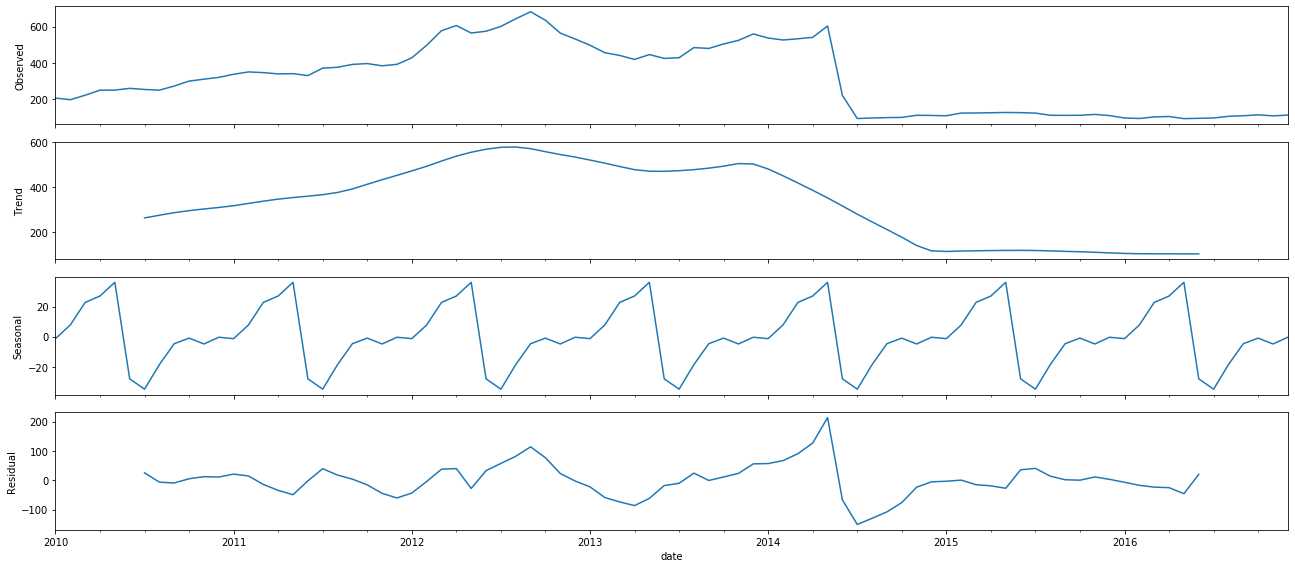

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y_apple , model='additive')
fig = decomposition.plot()
plt.show()

There's an obvious seasonality observed hence we will use SARIMA for our modeling

# Time series forecasting with ARIMA

__ARIMA which stands for Autoregressive Integrated Moving Average__

- ARIMA models are denoted with the notation ARIMA(p, d, q). </br>
- p for Auto regressive part as how many past values (p) our model is dependent on. </br>
- q for Moving Average part as how many past random error terms (q) our model is dependent on. </br>
- d for Integrated part as the number of times differencing is required to make it stationary.

In [33]:
#Setting the range of values for p,d and q
p = d = q = range(0, 2)

#Getting a list of possible cartesian products of (p,d,q) 
pdq = list(itertools.product(p, d, q))

#Setting the possible inputs for SARIMA
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Hyperparameter tuning to get all the possible values and their corresponding AIC scores. Storing the parameters that gives the best AIC score

In [34]:
def best_model():
    AIC = 1000
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(Y_apple ,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit(maxiter=800)
                if results.aic < AIC:
                    AIC = results.aic
                    best_param = param
                    best_seasonal = param_seasonal
            
            except:
                continue   
    
    return best_param,best_seasonal,AIC

In [35]:
param , param_seasonal , AIC = best_model()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, AIC))

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:636.5533319340964


The above output suggests that SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 636.55. Therefore we should consider this to be optimal option.



__Fitting the ARIMA model__

In [36]:
mod = sm.tsa.statespace.SARIMAX(Y_apple ,order=(0, 1, 1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2364      0.167      1.413      0.158      -0.092       0.564
ma.S.L12      -1.0000      0.072    -13.858      0.000      -1.141      -0.859
sigma2      2902.6769   2.49e-05   1.17e+08      0.000    2902.677    2902.677


Diagnostics to investigate any unusual behavior

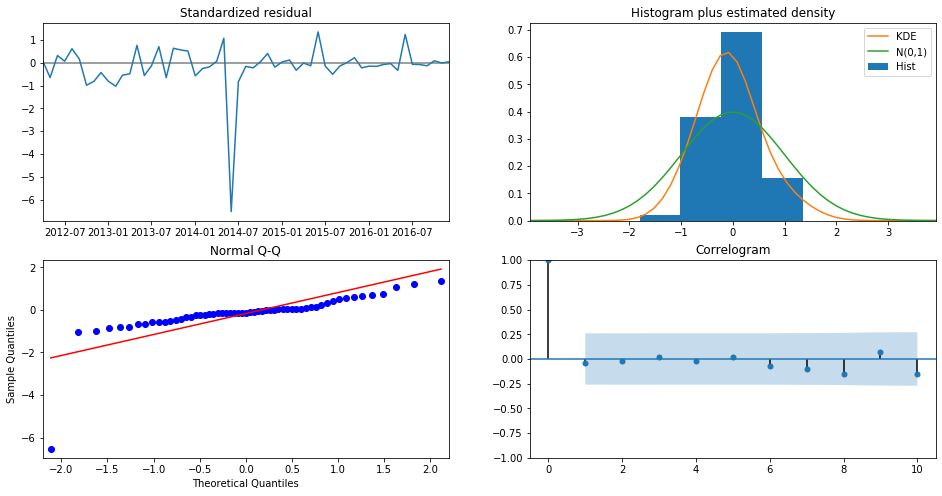

In [37]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- KDE plot that we got is similar to the normal distribution
- Quantile-Quantile plot also suggests it is nearly normally distributed

# Predicting the future values 

In [51]:
#Predicting the values starting fron 2016-01-01 to 2016-12-01
pred = results.get_prediction(start= pd.to_datetime('2016-01-01'), end = pd.to_datetime('2016-12-01') , dynamic=False)

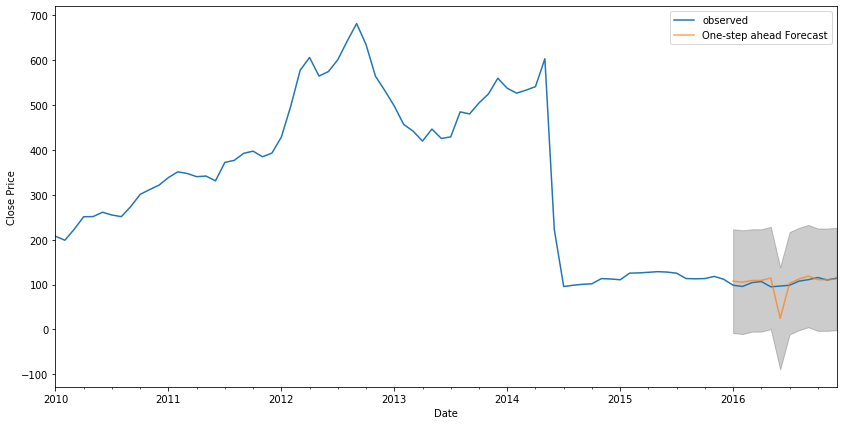

In [52]:
#Plotting the original closing price to predicted closing price graph

pred_ci = pred.conf_int()
ax = Y_apple.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

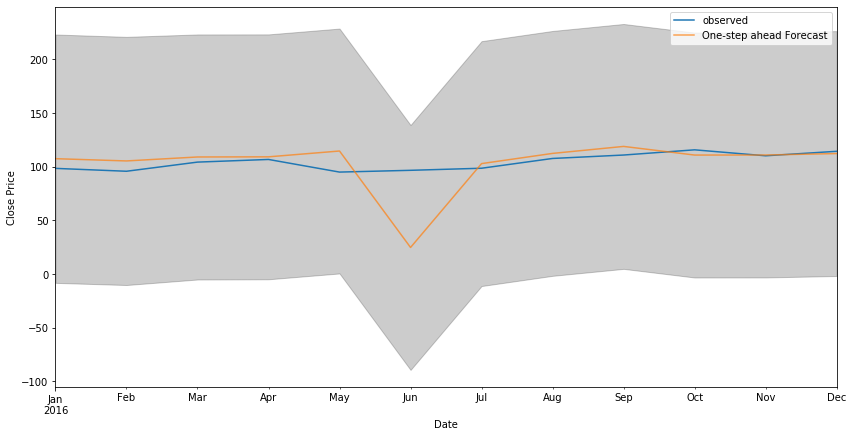

In [53]:
#Zooming on to the 2016 prediction graph
pred_ci = pred.conf_int()
ax = Y_apple.tail(12).plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

Comparing the results and getting the RMS value

In [54]:
y_pred = np.array(pred.predicted_mean)
y_actual = np.array(Y_apple.tail(12))

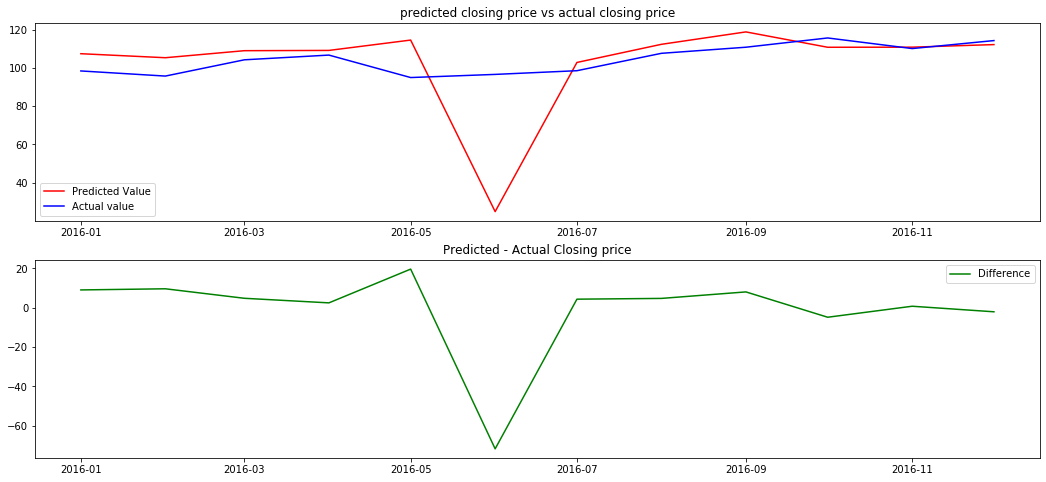

In [61]:
#Plotting the difference between the predicted and the actual value
from pylab import *

subplot(2,1,1)
title('predicted closing price vs actual closing price')
plot(pred_ci.index , y_pred , color = 'r' , label = 'Predicted Value')
plot(pred_ci.index , y_actual , color = 'b' , label = 'Actual value')
legend()

subplot(2,1,2)
title('Predicted - Actual Closing price')
plot(pred_ci.index , y_pred-y_actual , color = 'g' , label = 'Difference')

legend()
show()

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_pred))
rms

22.14644702823246

Clear dip in the difference in the predicted and the actual closing price resulted in such high RMS value 

Plotting the future predictions ranging till 2022. Getting the Maximum, Mean and Minimum predicted value 

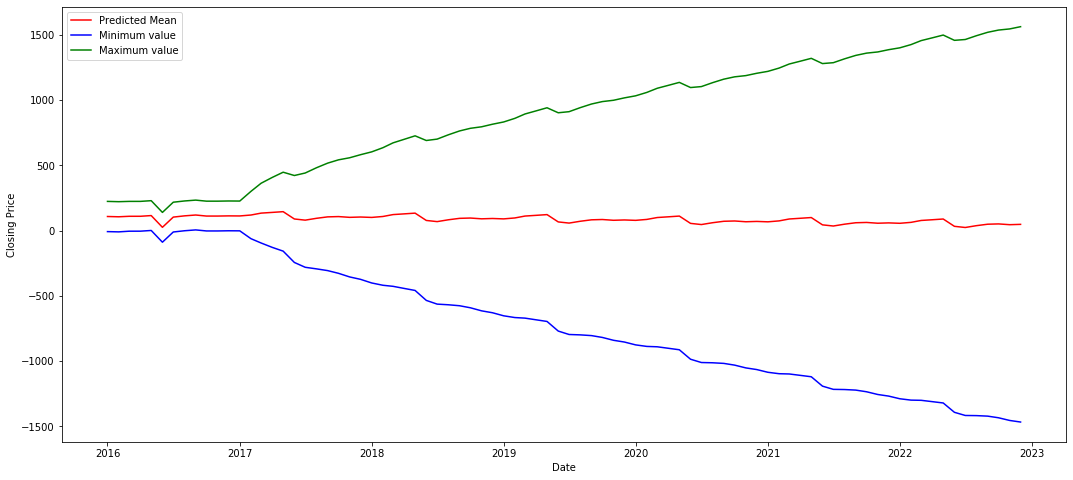

In [63]:
pred = results.get_prediction(start= pd.to_datetime('2016-01-01'), end = pd.to_datetime('2022-12-01') , dynamic=False)
pred_ci = pred.conf_int()
plt.plot(pred_ci.index, np.array(pred.predicted_mean),  color = 'red' , label = 'Predicted Mean')
plt.plot(pred_ci.index, np.array(pred_ci.iloc[:,0]),  color = 'blue' , label = 'Minimum value')
plt.plot(pred_ci.index, np.array(pred_ci.iloc[:,1]),  color = 'green' , label = 'Maximum value')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


__Conclusion__

- Strangely our model didn't perform well for the month of June which has resulted in such high RMS value. Other than that, predictions seems to be close to the actual values.
- Closing price doesn't seem to dip in near future which means Apple's going to perform well in near future. 